# Xu-Net

## Libraries

In [13]:
import numpy
import numpy as np
import random
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from keras.layers import Activation
import tensorflow as tf
import cv2
from tensorflow.keras.layers import Lambda, Layer, ReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LSTM, SpatialDropout2D, Concatenate
tf.keras.layers.Concatenate()
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, UpSampling2D, BatchNormalization
from keras.layers.core import Reshape
from keras import optimizers
from tensorflow.keras import regularizers
from keras import Input, Model
from time import time
import time as tm
from keras.initializers import Constant, RandomNormal, glorot_normal
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2
from keras import backend as K
from tensorflow.keras.utils import plot_model
from keras.layers import  concatenate

from tfkan.layers import DenseKAN
from tfkan.layers import Conv2DKAN
from tfkan.layers import base

## 30 SRM filters for preprocessing and the activation function

In [14]:
################################################## 30 SRM FILTERS
srm_weights = np.load('SRM_Kernels.npy') 
biasSRM=numpy.ones(30)
print (srm_weights.shape)
################################################## TLU ACTIVATION FUNCTION
T3 = 3;
def Tanh3(x):
    tanh3 = K.tanh(x)*T3
    return tanh3
##################################################

(5, 5, 1, 30)


## Functions

In [15]:
## DCT filters function

def make_DCT_filter():
    with tf.name_scope("DCT"):
        # Initialize DCT filters
        DCT_filter_n = np.zeros([5, 5, 1, 64])
        # Definition of 8x8 mesh grid
        XX, YY = np.meshgrid(range(5), range(5))
        # DCT basis as filters
        C=np.ones(5)
        C[0]=1/np.sqrt(2)
        for v in range(5):
            for u in range(5):
                DCT_filter_n[:, :, 0, u+v*5]=(2*C[v]*C[u]/5)*np.cos((2*YY+1)*v*np.pi/(10))*np.cos((2*XX+1)*u*np.pi/(10))

        DCT_filter=tf.constant(DCT_filter_n.astype(np.float32))

        return DCT_filter

def Fun(x):
    fun = tf.keras.activations.hard_sigmoid(x)*3
    return fun

def squeeze_excitation_layer(input_layer, out_dim, ratio, conv):
  squeeze = tf.keras.layers.GlobalAveragePooling2D()(input_layer)
  excitation = tf.keras.layers.Dense(units=out_dim / ratio, activation='relu')(squeeze)
  excitation = tf.keras.layers.Dense(out_dim,activation='sigmoid')(excitation)
  excitation = tf.reshape(excitation, [-1,1,1,out_dim])
  scale = tf.keras.layers.multiply([input_layer, excitation])
  
  if conv:
    shortcut = tf.keras.layers.Conv2D(out_dim,kernel_size=1,strides=1,
                                      padding='same',kernel_initializer='he_normal')(input_layer)
    shortcut = tf.keras.layers.BatchNormalization()(shortcut)
  else:
    shortcut = input_layer
  out = tf.keras.layers.add([shortcut, scale])
  return out

## Xu-Net architecture

In [24]:
def Xu_Net_strategy():
    
    img_size=256
    
    DCT_filter = make_DCT_filter()
    print(DCT_filter.shape)

    filters = np.concatenate([DCT_filter,srm_weights],axis=3)
    filters.shape
    
    bias = np.ones(94)

    tf.keras.backend.clear_session()
    inputs = tf.keras.Input(shape=(img_size,img_size,1), name="input")
    # Layer 1
    #conv0 =   tf.keras.layers.Conv2D(94, (5,5), weights=[filters,bias], strides=(1,1), trainable=False, activation=Tanh3, use_bias=True)(inputs)

    #Block 1
    layers_ty = tf.keras.layers.Conv2D(94, (5,5), weights=[filters,bias], strides=(1,1), trainable=False, padding='same', activation=Tanh3, use_bias=True)(inputs)
    layers_tn = tf.keras.layers.Conv2D(94, (5,5), weights=[filters,bias], strides=(1,1), trainable=True, padding='same', activation=Tanh3, use_bias=True)(inputs)
    layers1 = tf.keras.layers.add([layers_ty, layers_tn])

    
    layers = tf.keras.layers.Conv2D(94, (1,1), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers1) 
    layers = tf.keras.layers.ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
  
    layers = tf.keras.layers.Conv2D(94, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = tf.keras.layers.ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)

    layers = tf.keras.layers.Conv2D(94, (1,1), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = tf.keras.layers.ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    block_squeeze = squeeze_excitation_layer(layers, out_dim=94, ratio=32.0, conv=False)

    layers_Tr_1 = tf.keras.layers.add([layers1, block_squeeze])

    layers = tf.keras.layers.Conv2D(94, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers_Tr_1) 
    layers = tf.keras.layers.ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)

    layers = tf.keras.layers.Conv2D(94, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = tf.keras.layers.ReLU(negative_slope=0.1, threshold=0)(layers)
    layers3 = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)


    layers_Tr_2 = tf.keras.layers.add([layers_Tr_1, layers3])

    layers = tf.keras.layers.Conv2D(30, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers_Tr_2) 
    layers = tf.keras.layers.ReLU(negative_slope=0.1, threshold=0)(layers)
    layers_n = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)

    layers = tf.keras.layers.Conv2D(30, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers_n) 
    layers = tf.keras.layers.ReLU(negative_slope=0.1, threshold=0)(layers)
    layers4 = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = GlobalAveragePooling2D(data_format="channels_last")(layers4)
    
    #FC
    layers = DenseKAN(64)(layers)
    layers = DenseKAN(32)(layers)
    layers = DenseKAN(16)(layers)


    #Layer 18
    layers = DenseKAN(2)(layers)
    #Layer 19
    predictions = tf.keras.layers.Softmax(axis=1)(layers)
    model =tf.keras.Model(inputs = inputs, outputs=predictions)

    #Compile
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.95)
    
    if compile:
        model.compile(optimizer= optimizer,
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        print ("Xunet")
    return model

## Defining different functions to work with the architecture

In [17]:

def train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size, epochs, initial_epoch = 0, model_name=""):
    start_time = tm.time()
    log_dir="D:/modelos/"+model_name+"_"+"{}".format(time())
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir)
    filepath = log_dir+"/saved-model.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath, 
        monitor='val_accuracy', 
        save_best_only=True, 
        mode='max',
        verbose=1
    )
    model.reset_states()
    history=model.fit(X_train, y_train, epochs=epochs, 
                        callbacks=[tensorboard,  checkpoint], 
                        batch_size=batch_size,
                        validation_data=(X_valid, y_valid),
                        initial_epoch=initial_epoch)
    
    metrics = model.evaluate(X_test, y_test, verbose=0)
    results_dir="D:/modelos//"+model_name+"/"
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
      
        plt.figure(figsize=(10, 10))
        #plt.subplot(1,2,1)
        #Plot training & validation accuracy values
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Accuracy Vs Epochs')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.grid('on')
        plt.savefig(results_dir+'Accuracy_Xu_Net_'+model_name+'.eps', format='eps')
        plt.savefig(results_dir+'Accuracy_Xu_Net_'+model_name+'.svg', format='svg')
        plt.savefig(results_dir+'Accuracy_Xu_Net_'+model_name+'.pdf', format='pdf')
        plt.show()
        
        plt.figure(figsize=(10, 10))
        #plt.subplot(1,2,2)
        #Plot training & validation loss values
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Loss Vs Epochs')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.grid('on')
        plt.savefig(results_dir+'Loss_Xu_Net_'+model_name+'.eps', format='eps')
        plt.savefig(results_dir+'Loss_Xu_Net_'+model_name+'.svg', format='svg')
        plt.savefig(results_dir+'Loss_Xu_Net_'+model_name+'.pdf', format='pdf')
        plt.show()

    TIME = tm.time() - start_time
    print("Time "+model_name+" = %s [seconds]" % TIME)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [18]:
def Final_Results_Test(model,filename):

    if filename != ('train') and filename != ('validation'):
        print("\n\nBest")
        print(filename)
        model.load_weights(filename)
        loss,accuracy = model.evaluate(X_test, y_test,verbose=0)
        print(f'Loss={loss:.4f} y Accuracy={accuracy:0.4f}'+'\n') 


## Working with BOSSbase 1.01 WOW y PAYLOAD = 0.4bpp

In the README, there is a link to download the databases we use for the work. There are two databases BOSSbase 1.01 and Bows2+ BOSSbase 1.01, cover images and stego. You can choose the payload of 0.2 and 0.4 bpp for each of the databases.

In [19]:
#Train
X_train = np.load('data_load\X_train.npy')
y_train = np.load('data_load\y_train.npy')
#Valid
X_valid = np.load('data_load\X_valid.npy')
y_valid = np.load('data_load\y_valid.npy')
#Test
X_test = np.load('data_load\X_test.npy')
y_test = np.load('data_load\y_test.npy')

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)


(8000, 256, 256, 1)
(8000, 2)
(2000, 256, 256, 1)
(2000, 2)
(10000, 256, 256, 1)
(10000, 2)


## CNN name and algorithm 

In [20]:
base_name="04S-UNIWARD"
m_name="XU_Net_strategy"

## Training

(5, 5, 1, 64)
Xunet
Epoch 1/800
1000/1000 [==============================] - ETA: 0s - loss: 0.7508 - accuracy: 0.4916
Epoch 1: val_accuracy improved from -inf to 0.50100, saving model to D:/modelos/Model_XU_Net_strategy_04S-UNIWARD_1728689536.426332\saved-model.hdf5
1000/1000 [==============================] - 200s 196ms/step - loss: 0.7508 - accuracy: 0.4916 - val_loss: 0.7460 - val_accuracy: 0.5010
Epoch 2/800
1000/1000 [==============================] - ETA: 0s - loss: 0.7458 - accuracy: 0.5050
Epoch 2: val_accuracy did not improve from 0.50100
1000/1000 [==============================] - 196s 196ms/step - loss: 0.7458 - accuracy: 0.5050 - val_loss: 0.7439 - val_accuracy: 0.5010
Epoch 3/800
1000/1000 [==============================] - ETA: 0s - loss: 0.7440 - accuracy: 0.5040
Epoch 3: val_accuracy improved from 0.50100 to 0.50950, saving model to D:/modelos/Model_XU_Net_strategy_04S-UNIWARD_1728689536.426332\saved-model.hdf5
1000/1000 [==============================] - 196s 196ms/s

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


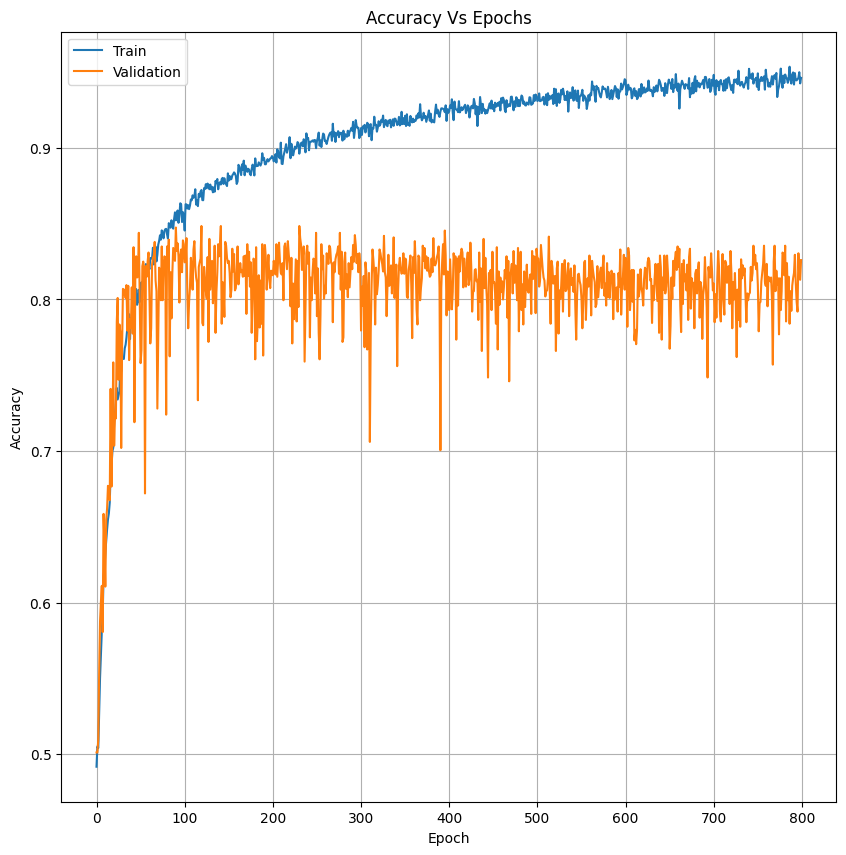

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


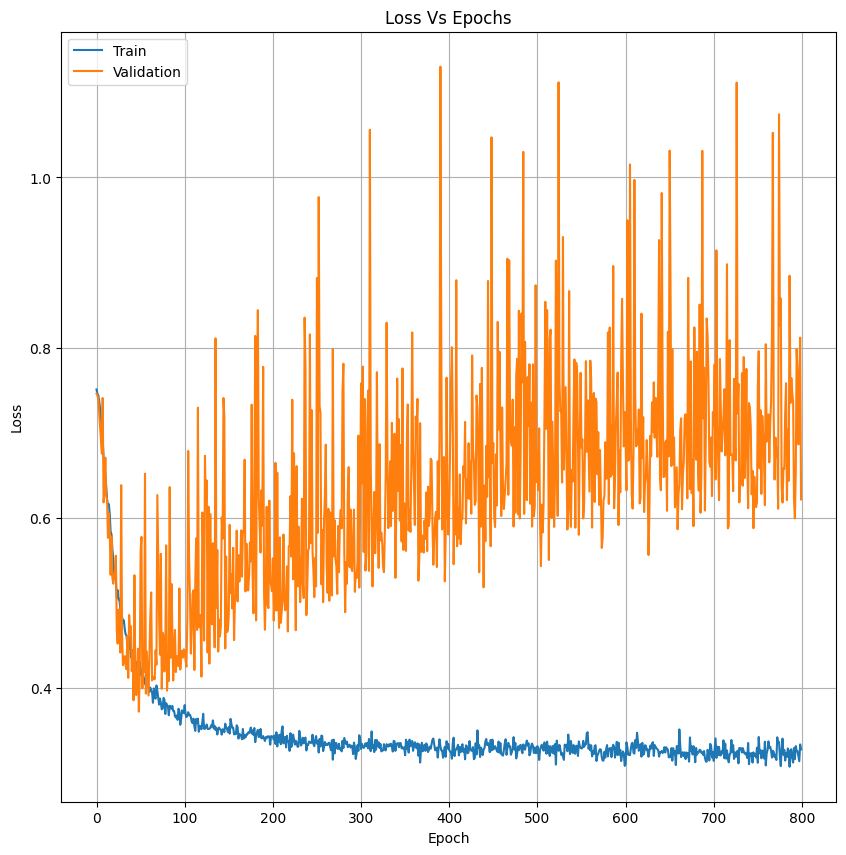

Time Model_XU_Net_strategy_04S-UNIWARD = 159559.9850513935 [seconds]


In [26]:
model= Xu_Net_strategy() 
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=8, epochs=800, model_name=name)

## Test

In [14]:
model= Xu_Net_strategy() 
PATH_trained_models = "D:\modelos\Model_XU_Net_04S-UNIWARD_1728342103.1582682\saved-model.hdf5"
Final_Results_Test(model,PATH_trained_models)

using 2 classes
Xunet


Best
D:\modelos\Model_XU_Net_04S-UNIWARD_1728342103.1582682\saved-model.hdf5
Loss=0.7837 y Accuracy=0.7031

